<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Modelo Seasonal ARIMA (SARIMA) e Grid Search Stepwise</font></b></strong>

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

A Média Móvel Integrada Autoregressiva Sazonal, SARIMA ou ARIMA Sazonal, é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com um componente sazonal.

Esse modelo adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

__Elementos de Tendência:__
 
No modelo SARIMA existem três elementos de tendência que requerem configuração. Eles são iguais ao modelo ARIMA, especificamente:

- p: Ordem de regressão automática da tendência.
- d: Ordem de diferenciação da tendência.
- q: Ordem média móvel de tendência.

__Elementos de Sazonalidade:__

E temos mais quatro elementos sazonais que não fazem parte do ARIMA e que devem ser configurados no modelo SARIMA. Eles são:

- P: Ordem autoregressiva sazonal.
- D: Ordem da diferença sazonal.
- Q: Ordem da média móvel sazonal.
- m: O número de etapas de tempo para um único período sazonal. Por exemplo, um S de 12 para dados mensais sugere um ciclo sazonal anual.

__Notação SARIMA:__
SARIMA(p,d,q)(P,D,Q,m)

********* ATENÇÃO *********

Fique sempre atento às letras maiúsculas e minúsculas, pois isso faz toda diferença na interpretação dos parâmetros de ordem do modelo.

Criaremos algumas versões de modelo SARIMA a partir desta aula, para nosso problema de previsão de vendas, usando diferentes estratégias de Grid Search para busca dos valores ideais dos parâmetros de ordem.

O pacote pmdarima será útil em nosso trabalho: https://alkaline-ml.com/pmdarima/index.html

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import pmdarima as pm
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels.api 0.11.1
sklearn         0.23.1
scipy           1.5.4
matplotlib      3.2.2
numpy           1.16.6
statsmodels     0.11.1
pmdarima        1.7.1
pandas          1.0.5
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [6]:
# Random seed 
np.random.seed(7)

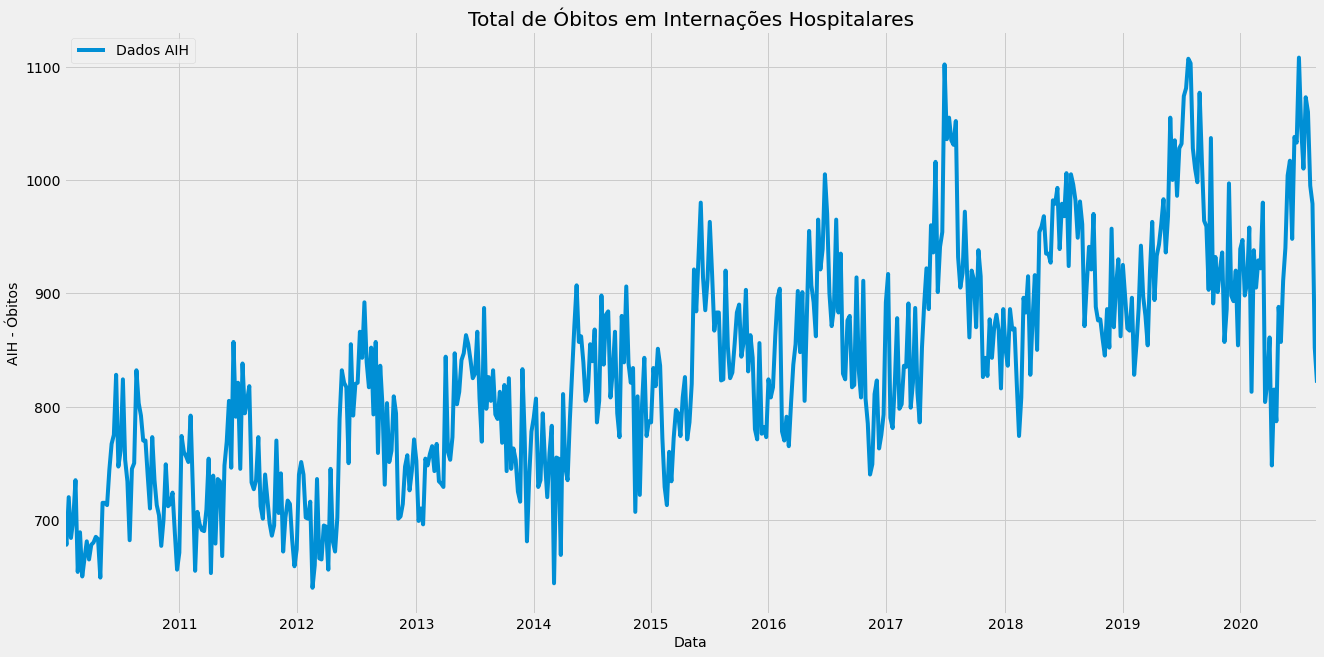

In [7]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo SARIMA

Até agora, restringimos nossa atenção aos dados não sazonais e aos modelos ARIMA não sazonais. No entanto, os modelos ARIMA também são capazes de modelar uma ampla variedade de dados sazonais.

A **Média Móvel Integrada Autoregressiva (ARIMA)** é um método de previsão para dados univariados de séries temporais.

Como o próprio nome sugere, ele suporta elementos médios autoregressivos e móveis. O elemento integrado refere-se à diferenciação, permitindo que o método suporte dados de séries temporais com uma tendência.

Um problema com o ARIMA é que ele não suporta dados sazonais, que é uma série temporal com um ciclo de repetição.

O ARIMA espera dados que não sejam sazonais ou que o componente sazonal seja removido, por exemplo, ajustado sazonalmente por métodos como diferenciação sazonal.

A **Média Móvel Integrada Autoregressiva Sazonal, SARIMA ou ARIMA Sazonal**, é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com um componente sazonal.

Ele adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

Um modelo ARIMA sazonal é formado pela inclusão de termos sazonais adicionais no ARIMA. A parte sazonal do modelo consiste em termos muito semelhantes aos componentes não sazonais do modelo, mas envolvem turnos alternados do período sazonal.

Um modelo ARIMA Sazonal é formado pela inclusão de termos sazonais adicionais nos modelos ARIMA que vimos até agora. Ou seja:

- Modelo ARIMA não sazonal = ARIMA(p, d, q)

- Modelo ARIMA sazonal = SARIMA(p,d,q)(P,D,Q,m)

Um modelo de média móvel integrada autoregressiva sazonal (SARIMA) é um passo diferente de um modelo ARIMA baseado no conceito de tendências sazonais. 

Em muitos dados de séries temporais, efeitos sazonais frequentes entram em cena. Tomemos, por exemplo, a temperatura média medida em um local com quatro estações. Haverá um efeito sazonal anualmente, e a temperatura nesta estação em particular definitivamente terá uma forte correlação com a temperatura medida no ano passado na mesma estação.

Considere o modelo SARIMA abaixo:

**SARIMA(3,1,0)(1,1,0)12**

O parâmetro m influencia os parâmetros P, D e Q. Por exemplo, um m de 12 para dados mensais sugere um ciclo sazonal anual.

O parâmetro P = 1 usaria a primeira observação sazonalmente deslocada no modelo, ou seja, t-(m * 1) ou t-12.

O parâmetro P = 2, usaria as duas últimas observações de compensação sazonal t-(m * 1), t-(m * 2).

Da mesma forma, um D de 1 calcularia uma diferença sazonal de primeira ordem e um Q = 1 usaria erros de primeira ordem no modelo (por exemplo, média móvel).

Um modelo ARIMA sazonal usa diferenciação em um atraso igual ao número de seasons para remover efeitos sazonais aditivos. Assim como na diferenciação do atraso 1 para remover uma tendência, a diferenciação do atraso introduz um termo médio móvel. O modelo ARIMA sazonal inclui termos médios autoregressivos e móveis em lag s.

### Grid Search Método 1 - Stepwise Search 

Usando um Modelo Auto-Arima para retornar os melhores parâmetros de ordem da série, para o menor valor possível da Estatística AIC.

Fazer uma análise manual completa de séries temporais pode ser uma tarefa tediosa, especialmente quando você tem muitos conjuntos de dados para analisar. É preferível automatizar a tarefa de seleção de modelo com a pesquisa em grade (Grid Search). Para o SARIMA, como temos muitos parâmetros, a pesquisa em grade pode levar horas para ser concluída em um conjunto de dados se definirmos o limite de cada parâmetro muito alto. Definir limites muito altos também tornará seu modelo muito complexo e superestimará os dados de treinamento.

Para evitar o longo tempo de execução e o problema de sobreajuste (overfitting), aplicamos o que é conhecido como princípio de parcimônia, onde criamos uma combinação de todos os parâmetros tais que p + d + q + P + D + Q ≤ 6. Outra abordagem é definir cada parâmetro como 0 ou 1 ou 2 e fazer a pesquisa na grade usando o AIC em cada combinação. 

Usaremos a segunda opção, chamada Grid Search Stepwise. Vou definir limites pequenos para os hiperparâmetros, mas você pode testar outros valores se desejar.

In [12]:
# Buscando pela ordem ideal para o modelo
# A função pm.auto_arima aplica o Grid Search e retorna o melhor modelo
modelo_v1 = pm.auto_arima(treino,
                          seasonal = True, 
                          m = 12,
                          d = 1, 
                          D = 1, 
                          max_p = 2, 
                          max_q = 2,
                          trace = True,
                          error_action = 'ignore',
                          suppress_warnings = True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4628.740, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4482.219, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4563.088, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4419.334, Time=0.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4479.129, Time=0.77 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4389.746, Time=1.42 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4450.317, Time=0.44 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.96 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=4383.315, Time=2.81 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=4442.31

Analisando o resultado do Grid Search Stepwise percebemos que este é o melhor modelo:

Fit ARIMA(1,1,2)x(2,1,0,12) (constant=True);  AIC=4371.955, Time=17.35 seconds


Melhor Modelo: 

- arima_order = (1, 1, 2)

- seasonal_order = (2, 1, 0, 12)

- AIC = 4371.955

In [13]:
# Print do sumário do melhor modelo encontrado
print(modelo_v1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  417
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 12)   Log Likelihood               -2179.977
Date:                             Wed, 25 Nov 2020   AIC                           4371.955
Time:                                     18:02:42   BIC                           4395.963
Sample:                                          0   HQIC                          4381.459
                                             - 417                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8783      0.039    -22.524      0.000      -0.955      -0.802
ma.L1          0.4039      

Vamos então usar os valores encontrados pelo Grid Search e treinar um modelo SARIMA.

A implementação no Statsmodels é chamada SARIMAX em vez de SARIMA e a adição de "X" ao nome do método significa que a implementação também suporta variáveis exógenas.

Essas são variáveis de séries temporais paralelas que não são modeladas diretamente pelos processos AR, I ou MA, mas são disponibilizadas como entrada ponderada para o modelo.

Variáveis exógenas são opcionais e podem ser especificadas através do argumento “exog”.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [14]:
# Cria o Modelo SARIMA
modelo_sarima_v1 = sm.tsa.statespace.SARIMAX(treino,
                                             order = (2, 1, 2),
                                             seasonal_order = (2, 1, 0, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html

In [15]:
# Treinamento (Fit) do modelo
modelo_sarima_v1_fit = modelo_sarima_v1.fit()

In [16]:
# Sumário do modelo
print(modelo_sarima_v1_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            QT_INTER   No. Observations:                  417
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 12)   Log Likelihood               -2045.069
Date:                             Wed, 25 Nov 2020   AIC                           4104.139
Time:                                     18:03:27   BIC                           4131.683
Sample:                                 01-10-2010   HQIC                          4115.071
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0786      0.418      0.188      0.851      -0.741       0.898
ar.L2         -0.1978      

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a troca do modelo ARIMA não sazonal pelo modelo ARIMA sazonal, o SARIMA. Saber escolher o modelo ideal a cada problema requer conhecimento sobre o maior número possível de modelos, o que sempre procuramos trazer nos cursos da Data Science Academy.

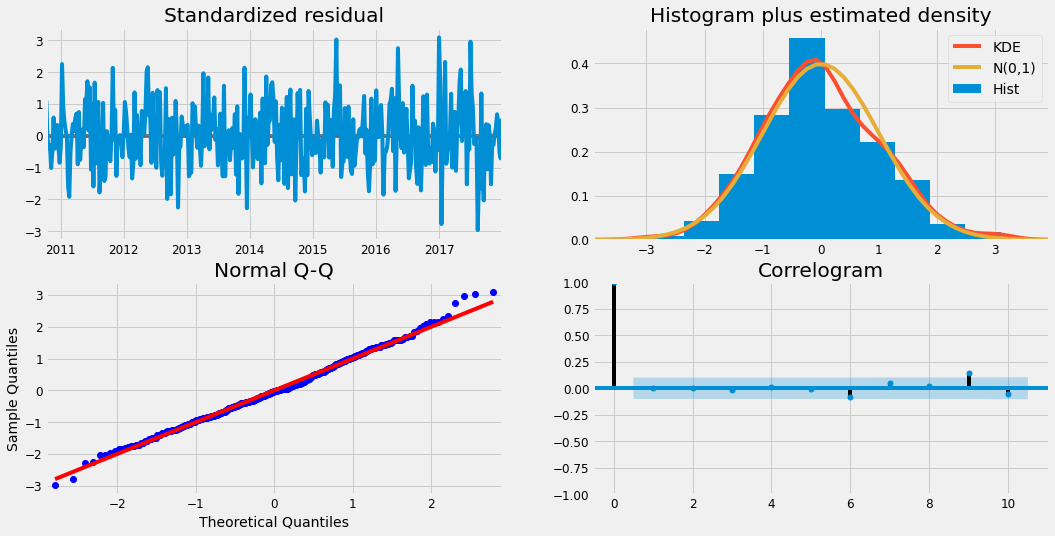

In [17]:
# Diagnóstico do modelo
modelo_sarima_v1_fit.plot_diagnostics(figsize = (16, 8))
plt.show()

Nas próximas aulas vamos interpretar esse diagnóstico e comparar as versões dos modelos SARIMA que iremos criar.

Uma vez ajustado, o modelo pode ser usado para fazer previsões.

Uma previsão pode ser feita chamando as funções forecast() ou predict() no objeto SARIMAXResults retornado do treinamento do modelo. Alternativamente podemos usar get_forecast() ou get_predict() se quisermos mais detalhes das previsões.

A função forecast() usa um único parâmetro que especifica o número de etapas de tempo fora da amostra a serem previstas ou assume uma previsão de uma etapa se nenhum argumento for fornecido.

A função predict faz o mesmo que forecast(), mas com uma limitação de sete passos no tempo.

In [18]:
# Vamos fazer previsões um passo a frente
sarima_predict_1 = modelo_sarima_v1_fit.get_prediction(start = pd.to_datetime('2018-01-01'), 
                                                       end = pd.to_datetime('2020-09-01'),
                                                       dynamic = False)

In [19]:
# Intervalo de confiança
sarima_predict_conf_1 = sarima_predict_1.conf_int()
#sarima_predict_conf_1

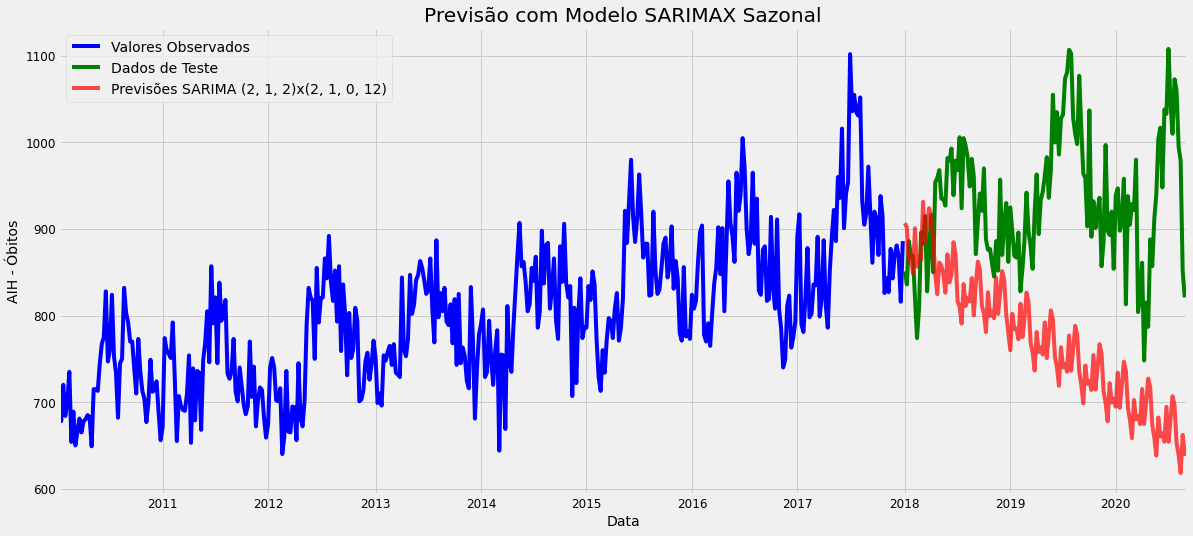

In [20]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_1.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (2, 1, 2)x(2, 1, 0, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
#ax.fill_between(sarima_predict_conf_1.index,
                # lower sales
#                sarima_predict_conf_1.iloc[:, 0],
                # upper sales
#                sarima_predict_conf_1.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão com Modelo SARIMAX Sazonal')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend()
plt.show()

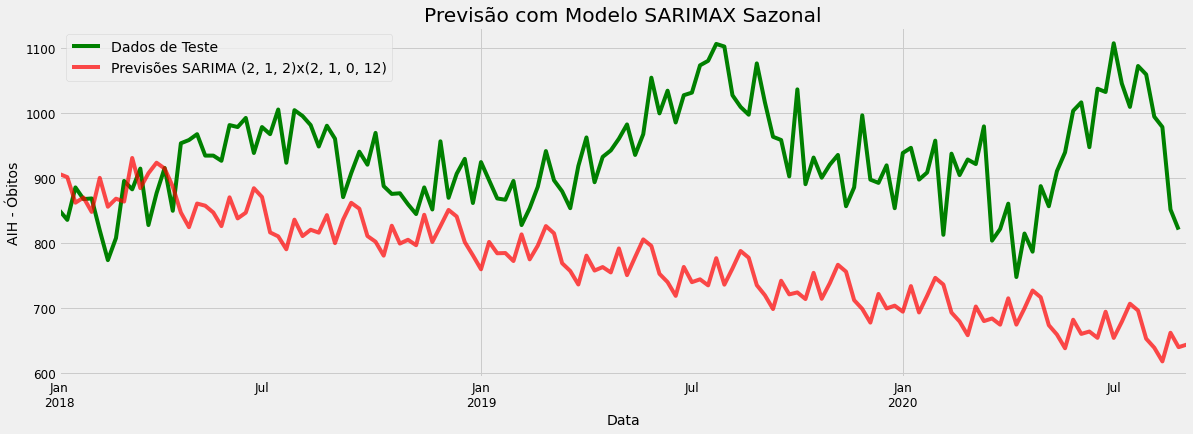

In [21]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 6

#ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_1.predicted_mean.plot(ax = t, 
                                     label = 'Previsões SARIMA (2, 1, 2)x(2, 1, 0, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Títulos e Legendas
plt.title('Previsão com Modelo SARIMAX Sazonal')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [22]:
# Calculando a performance
sarima_results = performance(treino, sarima_predict_1.predicted_mean)
#arima_results

MSE das previsões é nan
RMSE das previsões é nan
MAPE das previsões é nan


In [23]:
# Calculando a performance
sarima_results = performance(teste, sarima_predict_1.predicted_mean)
#sarima_results

MSE das previsões é 38820.4573
RMSE das previsões é 197.0291
MAPE das previsões é 17.6128


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [36]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_1 = modelo_sarima_v1_fit.get_forecast(steps = 140)

In [37]:
# Intervalo de confiança
horizonte_60_predict_1_conf_1 = horizonte_60_predict_1.conf_int()
#horizonte_60_predict_1_conf_1

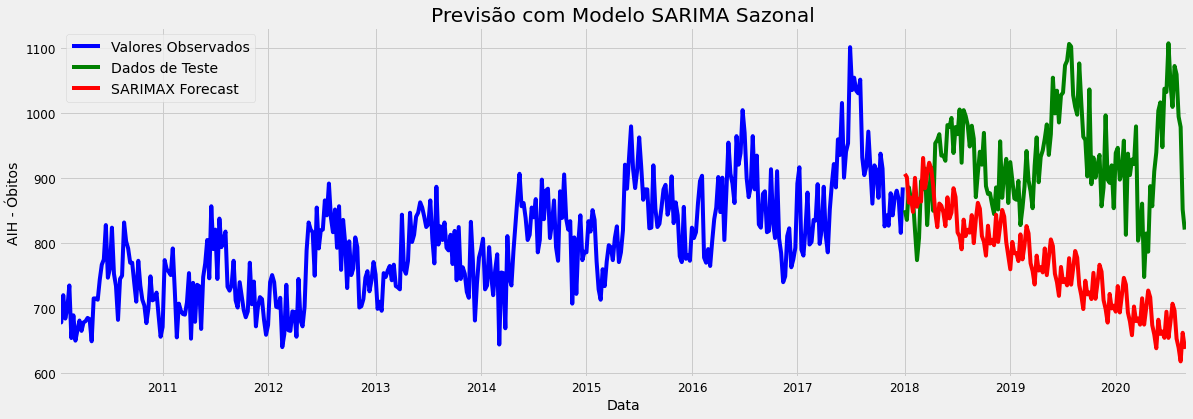

In [38]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 6

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
horizonte_60_predict_1.predicted_mean.plot(ax = t, label = 'SARIMAX Forecast', color = 'red')

# Plot
plt.title('Previsão com Modelo SARIMA Sazonal')
ax.set_xlabel('Data')
ax.set_ylabel('AIH - Óbitos')
plt.legend()
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [39]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v1_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.00025258]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

E, portanto, um modelo SARIMA(0, 1, 0)x(0, 1, 1, 12) fornece um bom ajuste e boa capacidade de previsão.

Como estamos até agora:
   
- Modelo 15 --> Modelo ARMA (4,5) - AIC = 38735.11 e RMSE = 236.8709
- Modelo 16 --> Modelo ARIMA Forcast (5,1,2) - AIC = 39559.670 e RMSE = 459.1013
- Modelo 17 --> Modelo SARIMA (2, 1, 2)x(2, 1, 0, 12) - AIC = 4104.139 e RMSE = 197.0291

Mesmo com a leve dimuniução no erro do modelo em relação às versões anteriores, a performance do modelo SARIMA é bem superior, o que fica evidenciado pela redução da Estatística AIC. 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim